# Titanic: who will survive?

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, linear_model, metrics

There are two data files: train.csv and test.csv. Let's download and analyze them. 

### Train dataset

In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X, y = df_train.drop('Survived', axis = 1), df_train['Survived']

### Test dataset

In [4]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data preprocessing

### NaN values

In [5]:
X.shape

(891, 11)

Let's check how many rows have missing values.

In [6]:
X.dropna().shape

(183, 11)

So we cannot just skip rows containing missing data because it's too many rows!
Instdead of it lets investigate how we can process these values.

Check what columns have missing values

In [7]:
for col in X.columns[X.isna().any()].to_list():
    print(col, ': ', X[col].isna().sum())

Age :  177
Cabin :  687
Embarked :  2


In [8]:
for col in df_test.columns[df_test.isna().any()].to_list():
    print(col, ': ', df_test[col].isna().sum())

Age :  86
Fare :  1
Cabin :  327


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

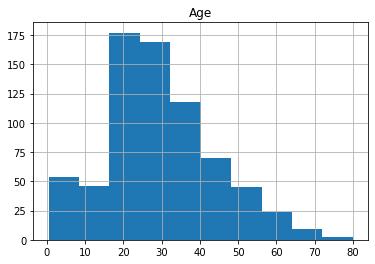

In [9]:
X.hist('Age')

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

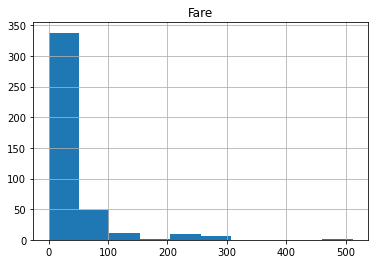

In [10]:
df_test.hist('Fare')

'Age' and 'Fare' missing values can be replaced with mean values 

In [11]:
numeric_columns = ['Age', 'Fare']
means = X[numeric_columns].mean(axis = 0)
X_train_updated = X.fillna(dict(zip(numeric_columns, means)))

means = df_test[numeric_columns].mean(axis = 0)
X_test_updated = df_test.fillna(dict(zip(numeric_columns, means)))

There are only 2 'Embarked' feature values are missed so we can just erase these rows. 

In [12]:
idx = X_train_updated['Embarked'].loc[pd.isna(X_train_updated['Embarked'])].index.to_list()
y.drop(idx, inplace = True)

X_train_updated.dropna(subset = ['Embarked'], axis = 0, inplace = True)
X_train_updated.shape

(889, 11)

'Cabin' values can be splitted as 'Cabin class' and 'Cabin number'

In [13]:
cabin_class_f = lambda x : ''.join([i for i in x.split()[0] if not i.isdigit()]) 
cabin_number_f = lambda x : ''.join([i for i in x.split()[0] if i.isdigit()]) 

#train
X_train_updated['CabinClass'] = [float('nan') if not isinstance(c, str) or not cabin_class_f(c)
         else cabin_class_f(c)
         for c in X_train_updated['Cabin']]

X_train_updated['CabinNumber'] = [float('nan') if not isinstance(c, str) or not cabin_number_f(c)
         else int(cabin_number_f(c))
         for c in X_train_updated['Cabin']]

X_train_updated.drop('Cabin', axis = 1, inplace = True)

#test
X_test_updated['CabinClass'] = [float('nan') if not isinstance(c, str) or not cabin_class_f(c)
         else cabin_class_f(c)
         for c in X_test_updated['Cabin']]

X_test_updated['CabinNumber'] = [float('nan') if not isinstance(c, str) or not cabin_number_f(c)
         else int(cabin_number_f(c))
         for c in X_test_updated['Cabin']]

X_test_updated.drop('Cabin', axis = 1, inplace = True)

<class 'pandas.core.series.Series'>


<AxesSubplot:>

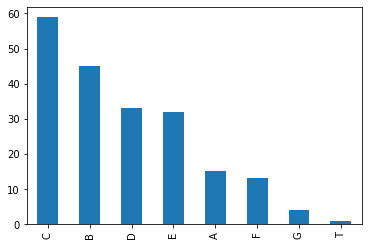

In [14]:
class_counter_train = X_train_updated['CabinClass'].dropna().value_counts()
print(type(class_counter_train))
class_counter_train.plot(kind = 'bar')

<class 'pandas.core.series.Series'>


<AxesSubplot:>

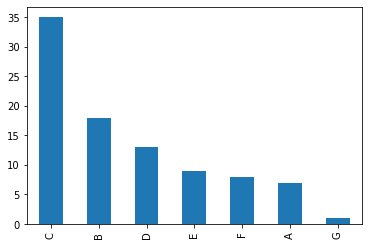

In [15]:
class_counter_test = X_test_updated['CabinClass'].dropna().value_counts()
print(type(class_counter_test))
class_counter_test.plot(kind = 'bar')

In [16]:
import random

Both train and test datasets have the same cabin classes (except T class in train dataset but it is ok). So we can use function which use only train dataset values for both train and test 'fillna' method. 

In [18]:
random.seed(0)
fill_nan_f = lambda x : random.choices(class_counter_train.index.to_list(), weights = class_counter_train.values)[0] if not isinstance(x, str) else x
X_train_updated['CabinClass'] = X_train_updated['CabinClass'].apply(fill_nan_f)
X_test_updated['CabinClass'] = X_test_updated['CabinClass'].apply(fill_nan_f)

In [19]:
X_train_updated.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinClass,CabinNumber
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,A,NaN
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,85.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,E,NaN
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,123.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,B,NaN


In [20]:
min_val = X_train_updated['CabinNumber'].min()
max_val = X_train_updated['CabinNumber'].max()

random.seed(0)
fill_nan_f = lambda x : random.randint(min_val, max_val) if not isinstance(x, str) else x

X_train_updated['CabinNumber'] = X_train_updated['CabinNumber'].apply(fill_nan_f)
X_test_updated['CabinNumber'] = X_test_updated['CabinNumber'].apply(fill_nan_f)

In [21]:
X_test_updated.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinClass,CabinNumber
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,B,63
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,E,27
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,B,41
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,C,107
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,C,56


'Name' and 'PassengedId' columns seem unnecessary so just drop them.

In [22]:
X_train_updated.drop(['Name', 'PassengerId'], axis = 1, inplace = True)

In [23]:
X_train_updated.drop('Ticket', axis = 1, inplace = True)

In [24]:
X_train_updated.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,CabinNumber
0,3,male,22.0,1,0,7.2500,S,A,100
1,1,female,38.0,1,0,71.2833,C,C,109
2,3,female,26.0,0,0,7.9250,S,E,12
3,1,female,35.0,1,0,53.1000,S,C,68
4,3,male,35.0,0,0,8.0500,S,B,132


In [25]:
X_train_updated.dtypes

Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
CabinClass      object
CabinNumber      int64
dtype: object

In [26]:
X_train_updated.isna().any()

Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
CabinClass     False
CabinNumber    False
dtype: bool

In [27]:
X_test_updated.drop(['Name', 'PassengerId', 'Ticket'], axis = 1, inplace = True)
X_test_updated.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,CabinNumber
0,3,male,34.5,0,0,7.8292,Q,B,63
1,3,female,47.0,1,0,7.0000,S,E,27
2,2,male,62.0,0,0,9.6875,Q,B,41
3,3,male,27.0,0,0,8.6625,S,C,107
4,3,female,22.0,1,1,12.2875,S,C,56


In [28]:
embarked_col = X_test_updated['Embarked'].append(X_train_updated['Embarked'])
cabin_class_col = X_test_updated['CabinClass'].append(X_train_updated['CabinClass'])
sex_col = X_test_updated['Sex'].append(X_train_updated['Sex'])

embarked_col = np.transpose(embarked_col.factorize()[0])
cabin_class_col = np.transpose(cabin_class_col.factorize()[0])
sex_col = np.transpose(sex_col.factorize()[0])

X_test_updated['Embarked'] = embarked_col[ : X_test_updated['Embarked'].size]
X_test_updated['CabinClass'] = cabin_class_col[ : X_test_updated['CabinClass'].size]
X_test_updated['Sex'] = cabin_class_col[ : X_test_updated['Sex'].size]

X_train_updated['Embarked'] = embarked_col[X_test_updated['Embarked'].size : ]
X_train_updated['CabinClass'] = cabin_class_col[X_test_updated['CabinClass'].size :]
X_train_updated['Sex'] = cabin_class_col[X_test_updated['Sex'].size :]

X_train_updated.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinClass,CabinNumber
0,3,5,22.0,1,0,7.2500,1,5,100
1,1,2,38.0,1,0,71.2833,2,2,109
2,3,1,26.0,0,0,7.9250,1,1,12
3,1,2,35.0,1,0,53.1000,1,2,68
4,3,0,35.0,0,0,8.0500,1,0,132


### Normilaze data and logistic regression

array([[<AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>, <AxesSubplot:>]],
      dtype=object)

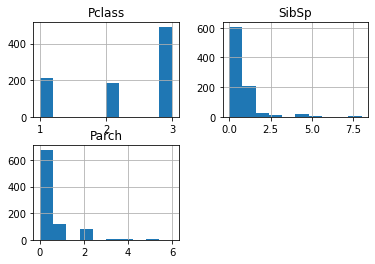

In [29]:
X_train_updated.hist(['Pclass', 'SibSp', 'Parch'])

See that 'Pclass' feature is categorical, 'SibSP' and 'Parch' - numeric

In [30]:
regressor = linear_model.LogisticRegression(random_state = 0)

In [31]:
from sklearn import pipeline, preprocessing

In [32]:
binary_data_columns = ['Sex']
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train_updated.columns], dtype = bool)
print(binary_data_indices)

[False  True False False False False False False False]


In [33]:
categorical_data_columns = ['Pclass', 'Embarked', 'CabinClass'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in X_train_updated.columns], dtype = bool)
print(categorical_data_indices)

[ True False False False False False  True  True False]


In [34]:
numeric_data_columns = ['SibSp', 'Parch', 'Fare', 'CabinNumber', 'Age']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train_updated.columns], dtype = bool)
print(numeric_data_indices)

[False False  True  True  True  True False False  True]


In [35]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [36]:
estimator.fit(X_train_updated, y)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000001D55E42A310>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001D55E42A3A0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0,
                                                                                 with_std=1))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                 

In [37]:
predictions = estimator.predict(X_test_updated)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1
 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1
 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 1 0 0 0 1 0 0 1 0 0 0]


## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf_cl = RandomForestClassifier(n_estimators = 50, max_features = 'sqrt', random_state = 0)
rf_cl.fit(X_train_updated, y)

RandomForestClassifier(max_features='sqrt', n_estimators=50, random_state=0)

In [40]:
predictions = rf_cl.predict(X_test_updated)